In [4]:
import numpy as np
import imageio
from typing import Tuple
from mip.display.image import show, read, subplot_images
import matplotlib.pyplot as plt
from scipy.ndimage import convolve  

In [5]:
def createGaussianBlurringOperator(
    size_I: Tuple[int, int], hsize: int, sigma: float
) -> np.ndarray:
    """
    Create a Gaussian blurring operator for an image of size size_I
    with a kernel size of hsize and a standard deviation of sigma
    """
    kernel = np.outer(
        np.exp(-np.linspace(-(hsize//2), hsize//2, hsize//2)) ** 2 / (2 * sigma**2),
        np.exp(-np.linspace(-(hsize//2), hsize//2, hsize//2)) ** 2 / (2 * sigma**2),
    )
    
    kernel = kernel / np.sum(kernel)
    fftFilter = np.fft.fft2(kernel, size_I)
    fftFilterc = np.conj(fftFilter)
    
    Op = lambda x: np.fft.ifft2(np.fft.fft2(x, size_I) * fftFilter).real
    Op_adj = lambda x: np.fft.ifft2(np.fft.fft2(x, size_I) * fftFilterc).real
    
    return Op, Op_adj, fftFilter

In [8]:
def deconv_van_cittert(f: np.ndarray, k_A: np.ndarray, iterations: int):
    u = f.copy()
    q = 1 - k_A
    for _ in range(iterations):
        u = f + np.fft.ifft2(np.fft.fft2(q * u)).real
    return u

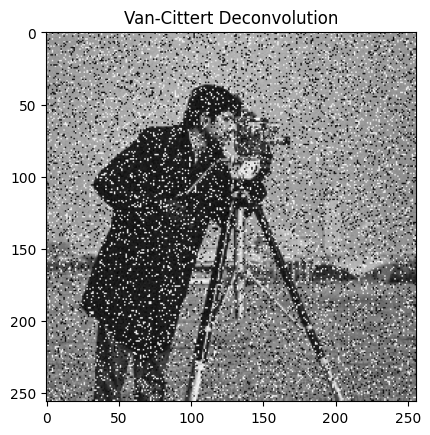

In [9]:
I = read("../assets/cameraman_sp.png", "GRAY")
I = I.astype(np.float64)

# Blurring and adding noise
Op, Op_adj, kA = createGaussianBlurringOperator(I.shape, 11, 2)
I_nse = Op(I) + 5 * np.random.randn(*I.shape)

# Deconvolution
iterations = 15
uv = deconv_van_cittert(I_nse, kA, iterations)

plt.figure()
plt.imshow(uv, cmap="gray")
plt.title("Van-Cittert Deconvolution")
plt.show()